Bibliotecas

In [397]:
import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

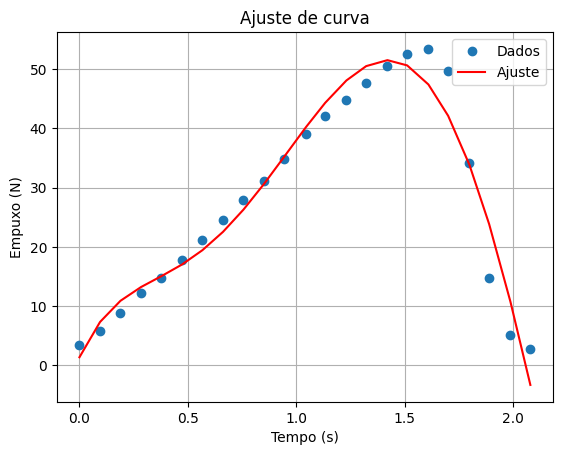

Curva ajustada: (79.70168604994986 * t) + (-205.22355146860954 * t**2) + (295.57366739446076 * t**3) + (-160.78355058940272 * t**4) + (27.40429708815195 * t**5) + 1.3475500051755298
Tempo de queima: 2.079 s
Empuxo médio: 27.775100000000002 N


In [421]:
data = pd.read_csv('Motor_SR1500_Sem_Óxido_dados.csv', sep=';', header=0)

def fit_curve(tempo, empuxo):
    def objective(x, a, b, c, d, e, f):
        return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

    popt, _ = curve_fit(objective, tempo, empuxo)
    return popt

def generate_curve(popt, x_values):
    a, b, c, d, e, f = popt
    return [(a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f for x in x_values]

popt = fit_curve(data['Tempo'], data['Empuxo'])
fitted_curve = generate_curve(popt, data['Tempo'])

plt.plot(data['Tempo'], data['Empuxo'], 'o', label='Dados')
plt.plot(data['Tempo'], fitted_curve, 'r-', label='Ajuste')
plt.xlabel('Tempo (s)')
plt.ylabel('Empuxo (N)')
plt.title('Ajuste de curva')
plt.legend()
plt.grid()
plt.show()

a, b, c, d, e, f = popt
curva = f'({a} * t) + ({b} * t**2) + ({c} * t**3) + ({d} * t**4) + ({e} * t**5) + {f}'

print(f'Curva ajustada: {curva}')
print(f'Tempo de queima: {data["Tempo"].iloc[-1]} s')
print(f'Empuxo médio: {data["Empuxo"].mean()} N')

# Save as .eng file
with open('Motor_SR1500_Sem_Óxido.eng', 'w') as f:
    f.write(';Motor_SR1500_Sem_Óxido RASP.ENG file\n')
    f.write(';Generated from experimental data\n')
    f.write(f';Total impulse: {data["Empuxo"].sum() * (data["Tempo"].iloc[1] - data["Tempo"].iloc[0]):.2f} Ns\n')
    f.write(f';Average thrust: {data["Empuxo"].mean():.2f} N\n')
    f.write(f';Burn time: {data["Tempo"].iloc[-1]:.2f} s\n')
    f.write('SR1500 38 150 5-10 0.175 0.852 Custom\n')  # Example header line, modify as needed
    for i in range(len(data)):
        f.write(f'{data["Tempo"].iloc[i]:.3f} {data["Empuxo"].iloc[i]:.3f}\n')
    f.write(f'{data["Tempo"].iloc[-1]:.3f} 0.000\n')  # Ensure the thrust ends at 0


---

Fase propulsada

Símbolos fase propulsada

$h(t) = V$

$\dot V = \sum F/m$ 

In [399]:
t, g, m, mp, ms, p, c, a, tq = sp.symbols('t g m mp ms p c a tq') # Variáveis tempo, gravidade, massa, massa do propelente, massa seca, 
                                                                    # densidade do meio (ar), coeficiente de arrasto, área de referência, tempo de queima

h = sp.symbols(r'h', cls=sp.Function)
h = h(t) # Altura
h_dot = sp.diff(h, t) # dh/dt (Velocidade)
h_ddot = sp.diff(h_dot, t) # d²h/dt² (Aceleração)

Equação para $\dot V = \sum F/m$ 

Onde:
- A massa m é uma função $m(t)$;
- O empuxo T é uma função $T(t)$;
- D é uma função $D(V)$

$\dot V = [-(P(m) + D(V)) + T(t)]/m$

In [ ]:
mt = mp + ms # Massa total
m = mt - ((mp/tq)*t) # Função da massa
P = m * g # Força peso

D = 0.5 * p * h_dot**2 * c * a # Força de arrasto

E = (79.70168604994986 * t) + (-205.22355146860954 * t**2) + (295.57366739446076 * t**3) + (-160.78355058940272 * t**4) + (27.40429708815195 * t**5) + 1.3475500051755298
T = E # Força de empuxo


vdot = (-P - D + T)/m 

dvdt = sp.Eq(vdot, h_ddot) # Equação da aceleração
sol= sp.solve([dvdt],[h_ddot])

dvdt.simplify() 

Eq(Derivative(h(t), (t, 2)), (-g*(-mp*t + tq*(mp + ms)) - tq*(0.5*a*c*p*Derivative(h(t), t)**2 - 27.4042970881519*t**5 + 160.783550589403*t**4 - 295.573667394461*t**3 + 205.22355146861*t**2 - 79.7016860499499*t - 1.34755000517553))/(-mp*t + tq*(mp + ms)))

Transformação para equações solucionáveis (Método ODEint)

In [401]:
ddhddt_f = sp.lambdify((h_dot, t, g, mp, ms, p, c, a, tq), sol[h_ddot]) # Função da aceleração 
dhdt_f = sp.lambdify(h_dot, h_dot) # Função da velocidade 
pesot = sp.lambdify((t, mp, ms, tq, g), P) # Função da massa total

# Sistema de equações
def dSdt(S, t, g, mprop, mseco, ro, cd, af, tq):
    h, hd = S

    return [dhdt_f(hd),
            ddhddt_f(hd, t, g, mprop, mseco, ro, cd, af, tq)]

Condições iniciais do lançamento

In [402]:
tq = 2.079 # Tempo de queima (s)
tempo_simulacao1 = tq # Tempo fase propulsada
passo = 1000  # 1e-3
t1 = np.linspace(0, tempo_simulacao1, passo+1) # Vetor de tempo 1
mp = 0.175 # Massa do propelente (kg)
ms = 0.852-0.175 # Massa seca (kg)
p = 1.2754 # Densidade do ar (kg/m³)
g = 9.81 # Aceleração da gravidade (m/s²)
cd = 0.4 # Coeficiente de arrasto
diam = 0.04 # Diâmetro do foguete (m)
af = np.pi * (diam**2)/4 # Área de referência (m²)
h0 = 0 # Altura inicial
hd0 = 0 # Velocidade inicial

solve = odeint(dSdt, y0=[h0, hd0], t=t1, args=(g, mp, ms, p, cd, af, tq))

Obtenção das soluções de $h(t)$ e $v(t)$

A altura máxima atingida durante a fase propulsada é chamada de altura de burnout

In [403]:
hpos = solve.T[0] # Altura
hdot = solve.T[1] # Velocidade

print(f'Altura de burnout: {max(hpos):.2f} m')

Altura de burnout: 48.05 m


A trajetória e velocidade da fase propulsada são:

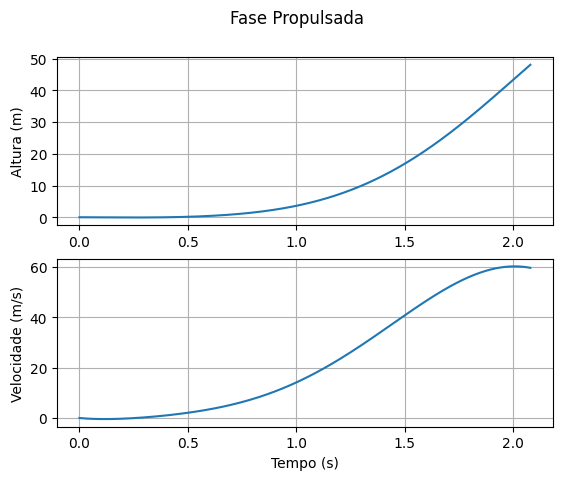

In [404]:
fig, axs = plt.subplots(2)

fig.suptitle('Fase Propulsada')

axs[0].plot(t1, hpos)
axs[0].set_ylabel('Altura (m)')
axs[0].grid()
axs[1].plot(t1, hdot)
axs[1].set_ylabel('Velocidade (m/s)')
axs[1].grid()

plt.xlabel('Tempo (s)')
plt.show()

----

Fase balística

Símbolos da fase balística

$h(t) = V$

$\dot V = \sum F/m$ 

In [405]:
t, g, m, ms, p, c, a = sp.symbols('t g m ms p c a') # Variáveis tempo, gravidade, massa, massa seca, densidade do meio (ar), coeficiente de arrasto, área de referência

h2 = sp.symbols(r'h', cls=sp.Function)
h2 = h2(t) # Altura
h_dot2 = sp.diff(h2, t) # dh/dt (Velocidade)
h_ddot2 = sp.diff(h_dot2, t) # d²h/dt² (Aceleração)

Equação para $\dot V = \sum F/m$ 

Onde:
- A massa m é constante;
- O empuxo T não atua mais;
- D é uma função $D(V)$

$\dot V = -(P + D(V))/m$

In [406]:
m = ms # Massa seca constante
P = m * g # Força peso constante

D = 0.5 * p * h_dot2**2 * c * a # Força de arrasto

vdot2 = -(P + D)/m

dvdt2 = sp.Eq(vdot2, h_ddot2) # Equação da aceleração
sol2 = sp.solve([dvdt2],[h_ddot2])

dvdt2.simplify()

Eq(Derivative(h(t), (t, 2)), -0.5*a*c*p*Derivative(h(t), t)**2/ms - g)

Transformação novamente para equações solucionáveis (Método ODEint)

In [407]:
ddhddt_f2 = sp.lambdify((h_dot2, g, ms, p, c, a), sol2[h_ddot2]) # Função da aceleração
dhdt_f2 = sp.lambdify(h_dot2, h_dot2) # Função da velocidade

# Sistema de equações
def dSdt(S, t, g, mseco, ro, cd, af):
    h, hd = S
    
    return [dhdt_f2(hd),
            ddhddt_f2(dhdt_f2(hd), g, mseco, ro, cd, af)]

Condições iniciais da fase balística

In [408]:
tempo_simulacao2 = 11 # Tempo fase balística (aproximar experimentalmente até o apogeu) (s) #8
passo = 1000 # 1e-3
t2 = np.linspace(0, tempo_simulacao2, passo+1) # Vetor de tempo 2
ms = 0.852-0.175 # Massa seca (kg)
p = 1.2754 # Densidade do ar (kg/m³)
g = 9.81 # Aceleração da gravidade (m/s²)
cd = 0.4 # Coeficiente de arrasto
diam = 0.04 # Diâmetro do foguete (m)
af = np.pi * (diam**2)/4 # Área de referência (m²)
h0 = hpos[-1] # Altura final da fase propulsada
hd0 = hdot[-1] # Velocidade final da fase propulsada

solve2 = odeint(dSdt, y0=[h0, hd0], t=t2, args=(g, ms, p, cd, af))

In [409]:
hpos2 = solve2.T[0] # Altura
hdot2 = solve2.T[1] # Velocidade

Trajetória da fase balística

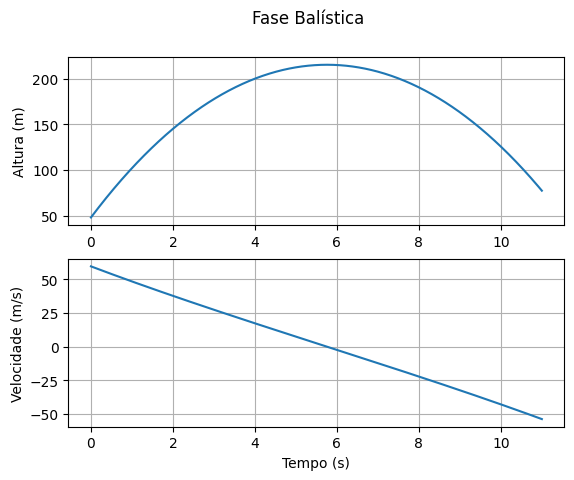

In [410]:
fig, axs = plt.subplots(2)

fig.suptitle('Fase Balística')

axs[0].plot(t2, hpos2)
axs[0].set_ylabel('Altura (m)')
axs[0].grid()
axs[1].plot(t2, hdot2)
axs[1].set_ylabel('Velocidade (m/s)')
axs[1].grid()

plt.xlabel('Tempo (s)')
plt.show()

---

Fase sustentada

Mantem-se as variáveis anteriores, porém o Coeficiente de Arrasto e Área de Referência são validados pelo paraquedas

In [411]:
t, g, m, ms, p, c, a = sp.symbols('t g m ms p c a') # Variáveis tempo, gravidade, massa, massa seca, densidade do meio (ar), coeficiente de arrasto, área de referência

h = sp.symbols(r'h', cls=sp.Function)
h = h(t) # Altura
h_dot = sp.diff(h, t) # dh/dt (Velocidade)
h_ddot = sp.diff(h_dot, t) # d²h/dt² (Aceleração)

In [412]:
m = ms # Massa seca constante
P = m * g # Força peso constante

D = 0.5 * p * h_dot**2 * c * a # Força de arrasto

vdot3 = (-P + D)/m

dvdt3 = sp.Eq(vdot3, h_ddot) # Equação da aceleração
sol3 = sp.solve([dvdt3],[h_ddot])

dvdt3.simplify()

Eq(Derivative(h(t), (t, 2)), 0.5*a*c*p*Derivative(h(t), t)**2/ms - g)

In [413]:
ddhddt_f3 = sp.lambdify((h_dot, t, g, ms, p, c, a), sol3[h_ddot]) # Função da aceleração
dhdt_f3 = sp.lambdify(h_dot, h_dot) # Função da velocidade

# Sistema de equações
def dSdt(S, t, g, mseco, ro, cd, af):
    h, hd = S

    return [dhdt_f3(hd),
            ddhddt_f3(hd, t, g, mseco, ro, cd, af)]

In [414]:
tempo_simulacao3 = 11 # Tempo fase sustentada (aproximar experimentalmente até a queda) (s) #96.5
passo = 1000 # 1e-3
t3 = np.linspace(0, tempo_simulacao3, passo+1) # Vetor de tempo 2
ms = 0.852-0.175 # Massa seca (kg)
p = 1.2754 # Densidade do ar (kg/m³)
g = 9.81 # Aceleração da gravidade (m/s²)
cd_pq = 0.9 # Coeficiente de arrasto (paraquedas)
diam_pq = 0.6 # Diâmetro do paraquedas (m)
af = np.pi * (diam_pq**2)/4 # Área de referência (m²)
h0 = hpos2[-1] # Altura final da fase balística
hd0 = hdot2[-1] # Velocidade final da fase balística

solve3 = odeint(dSdt, y0=[h0, hd0], t=t3, args=(g, ms, p, cd_pq, af)) 

In [415]:
hpos3 = solve3.T[0] # Altura
hdot3 = solve3.T[1] # Velocidade

Trajetória da fase sustentada

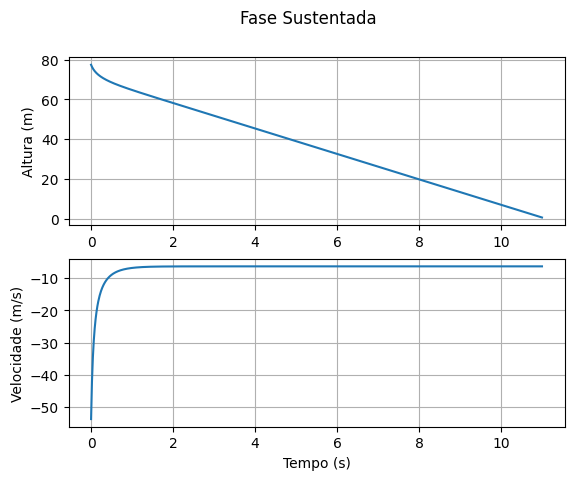

In [416]:
fig, axs = plt.subplots(2)

fig.suptitle('Fase Sustentada')

axs[0].plot(t3, hpos3)
axs[0].set_ylabel('Altura (m)')
axs[0].grid()
axs[1].plot(t3, hdot3)
axs[1].set_ylabel('Velocidade (m/s)')
axs[1].grid()

plt.xlabel('Tempo (s)')
plt.show()

---

Juntando todas trajetórias

In [417]:
nt = np.append(t1, t2+t1[-1]) # Vetor de tempo propulsado + balístico
nh = np.append(hpos, hpos2) # Vetor de altura propulsado + balístico
nv = np.append(hdot, hdot2) # Vetor de velocidade propulsado + balístico

nt = np.append(nt, t3+nt[-1]) # Vetor de tempo total (propulsado + balístico + sustentado)
nh = np.append(nh, hpos3) # Vetor de altura total (propulsado + balístico + sustentado)
nv = np.append(nv, hdot3) # Vetor de velocidade total (propulsado + balístico + sustentado)

nfa = 0.5 * p * hdot**2 * cd * af # Força de arrasto propulsado
nfa = np.append(nfa, 0.5 * p * hdot2**2 * cd * af) # Força de arrasto propulsado + balístico
nfa = np.append(nfa, 0.5 * p * hdot3**2 * cd_pq * af) # Força de arrasto total (propulsado + balístico + sustentado)

nfp = m * g # Força peso propulsado

print(f'Apogeu atingido: {max(nh):.2f} m')
print(f'Tempo até o apogeu: {nt[np.where(nh==max(hpos2))[0][0]]:.2f} s')
print(f'Velocidade máxima atingida: {max(abs(nv)):.2f} m/s ({max(abs(nv))*3.6:.2f} km/h)')
print(f'Tempo de queda: {tempo_simulacao3 - nt[np.where(nh==hpos2[-1])[0][0]]:.2f} s')
print(f'Velocidade de impacto: {abs(hdot3[-1]):.2f} m/s ({abs(hdot3[-1])*3.6:.2f} km/h)')
print(f'Tempo de voo: {nt[-1]:.2f} s')

Apogeu atingido: 215.08 m
Tempo até o apogeu: 7.84 s
Velocidade máxima atingida: 60.17 m/s (216.61 km/h)
Tempo de queda: -2.08 s
Velocidade de impacto: 6.40 m/s (23.03 km/h)
Tempo de voo: 24.08 s


Apogeu atingido: 215.08 m | Tempo até o apogeu: 7.84 s
Velocidade máxima atingida: 60.17 m/s (216.61 km/h) | Tempo de voo: 24.08 s


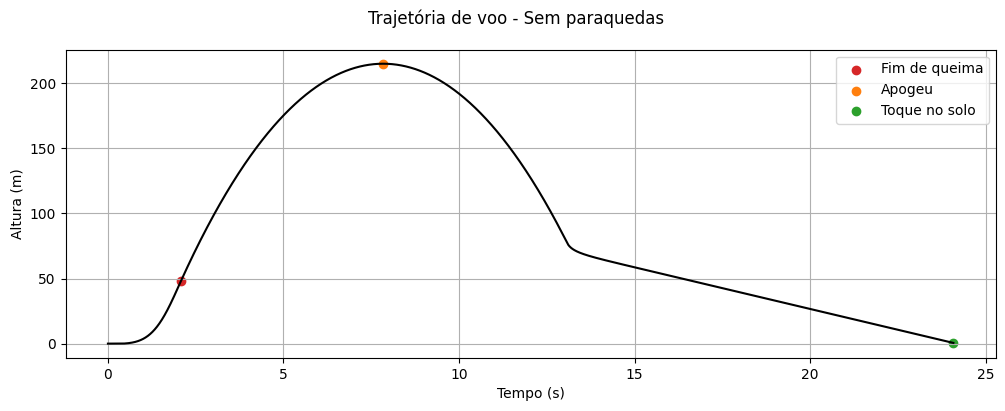

In [418]:
fig, axs = plt.subplots(figsize=(12,4))

fig.suptitle('Trajetória de voo - Sem paraquedas')
axs.plot(nt, nh, c='k')
axs.scatter(nt[np.where(nh==hpos[-1])[0][0]], nh[np.where(nh==hpos[-1])[0][0]], label='Fim de queima', c='tab:red')
axs.scatter(nt[np.where(nh==max(hpos2))[0][0]], nh[np.where(nh==max(hpos2))[0][0]], label='Apogeu', c='tab:orange')
# axs[0].scatter(nt[np.where(nh==hpos2[-1])[0][0]], nh[np.where(nh==hpos2[-1])[0][0]], label='Abertura do paraquedas', c='tab:blue')
axs.scatter(nt[np.where(nh==nh[-1])], nh[np.where(nh==nh[-1])], label='Toque no solo', c='tab:green')
axs.legend(loc="upper right")
axs.set_ylabel('Altura (m)')
axs.grid()
# axs[1].plot(nt, nv, c='k')
# axs[1].scatter(nt[np.where(nv==hdot[-1])[0][0]], nv[np.where(nv==hdot[-1])[0][0]], label='Fim de queima', c='tab:red')
# axs[1].scatter(nt[np.where(nh==max(hpos2))[0][0]], nv[np.where(nh==max(hpos2))[0][0]], label='Apogeu', c='tab:orange')
# # axs[1].scatter(nt[np.where(nh==hpos2[-1])], nv[np.where(nh==hpos2[-1])], label='Abertura do paraquedas', c='tab:blue')
# axs[1].scatter(nt[np.where(nh==nh[-1])], nv[np.where(nh==nh[-1])], label='Toque no solo', c='tab:green')
# axs[1].set_ylabel('Velocidade (m/s)')
# axs[1].grid()
plt.xlabel('Tempo (s)')

print(f'Apogeu atingido: {max(nh):.2f} m | Tempo até o apogeu: {nt[np.where(nh==max(hpos2))[0][0]]:.2f} s')
print(f'Velocidade máxima atingida: {max(abs(nv)):.2f} m/s ({max(abs(nv))*3.6:.2f} km/h) | Tempo de voo: {nt[-1]:.2f} s')
plt.show()